In [1]:
# Importing Libraries
import tables
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/Users/eframe/dmi/src')
import compton2 
import matplotlib.ticker as ticker
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import xlogy, erf
import math as m

In [2]:
# Inputs for Compton image reconstruction
E, sigma = 440, 2
mu_low, mu_high = -0.4, 1
lever_thres = 14

poses = np.array( [ 0 ] ) * np.pi / 180
inputs = np.array( [ '/Users/eframe/Downloads/micro1_COMP.h5'] )

binSize = 1
sourceX, sourceY, sourceZ = np.mgrid[ -19:21:binSize, -19:21:binSize, -19:21:binSize ]
sourcePixels = np.array( [ sourceX.flatten(), sourceY.flatten(), sourceZ.flatten() ] ).T

In [3]:
# Getting Compton cones from detector data for each pose
interPos, coneDir, coneMu = [], [], []
for i in np.arange( len( inputs ) ):
    f = tables.open_file( inputs[ i ], 'r' )
    time = f.root.EventData.read()['timestamp']
    duration = ( time[-1] * 10 ** -8 - time[0] * 10 ** -8 ) / 60
    print('minutes:', duration)
    d = f.root.Interactions.Double.read()
    d['x'] = d['x'] - 38 
    d['y'] = d['y'] - 38  
    l22 = d.reshape( int ( len ( d ) / 2 ), 2 ) 

    # Getting Cone Data
    emask = ( l22['energy'].sum( axis = 1 ) >= E - sigma ) & ( l22['energy'].sum( axis = 1 ) <= E + sigma )   
    events_old = l22[emask]
    events = compton2.correct_depth( events_old )
    events['z'] = -events['z']
    
    iP, iP2, cD, cM = compton2.convertToConeData( events, E, lever_thres )
    
    # Sequencing Interactions
    energy1 = np.array( [ events['energy' ][ :, 0 ], events['energy'][ :, 1 ] ] ).T
    energy2 = np.array( [ events['energy' ][ :, 1 ], events['energy'][ :, 0 ] ] ).T
    p1 = np.squeeze( np.array( [ events['x'][ :, 0 ], events['y'][ :, 0 ], events['z'][ :, 0 ] ] ) ).T
    p2 = np.squeeze( np.array( [ events['x'][ :, 1 ], events['y'][ :, 1 ], events['z'][ :, 1 ] ] ) ).T
    pos1 = np.concatenate( ( [ p1, p2 ] ) , axis = 1 ).reshape( len( p1 ), 2, 3 )
    pos2 = np.concatenate( ( [ p2, p1 ] ) , axis = 1 ).reshape( len( p1 ), 2, 3 )

    P12, P21 = compton2.sequence_probability( energy1, pos1, E )
    mask = ( P12 < P21 )
    energy = energy1.copy()
    energy[mask] = energy2[mask]
    pos = pos1.copy()
    pos[mask] = pos2[mask]
    iP, iP2, cD, cM = compton2.convertToConeData_SEQ( energy, pos, E, lever_thres )
    
    mask = ( cM > mu_low ) & ( cM < mu_high )
    interPos.append( iP[mask] )
    coneMu.append( cM[mask] )
    coneDir.append( cD[mask] )

minutes: 75.01614734533334


In [4]:
# interPos2 = np.concatenate( ( interPos[0], interPos[1] ) )
# interPos3 = interPos2.reshape( ( 1, interPos2.shape[0], interPos2.shape[1] ) )
# coneDir2 = np.concatenate( ( coneDir[0], coneDir[1] ) )
# coneDir3 = coneDir2.reshape( ( 1, coneDir2.shape[0], coneDir2.shape[1] ) )
# coneMu2 = np.concatenate( ( coneMu[0], coneMu[1] ) )
# coneMu3 = coneMu2.reshape( ( 1, coneMu2.shape[0] ) )
# interPos = interPos3.copy()
# coneDir = coneDir3.copy()
# coneMu = coneMu3.copy()

0.0


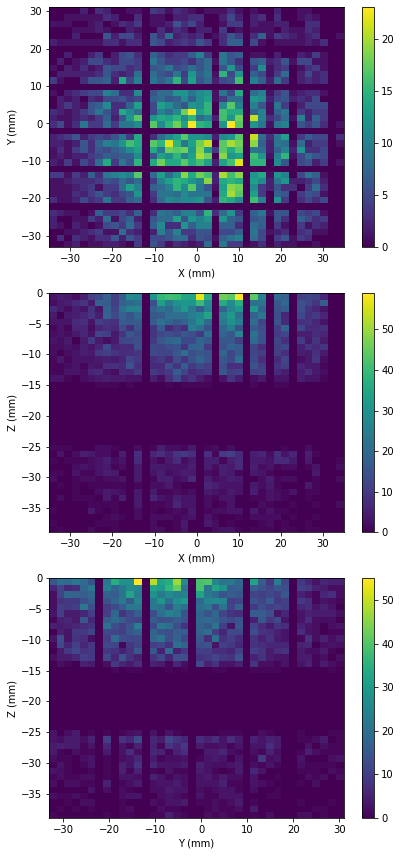

In [5]:
# Heatmap of interaction locations
get_ipython().run_line_magic('matplotlib', 'inline')
for i in np.arange( len( interPos ) ):
    print( poses[i] )
    pos = interPos[i]
    plt.figure( figsize=( 6,12 ) )
    # XY
    plt.subplot( 311 )
    plt.hist2d( pos[ :, 0 ], pos[ :, 1 ], bins = ( 38, 38 ) )
    plt.colorbar()
    plt.xlabel( "X (mm)" )
    plt.ylabel( "Y (mm)" )
    # XZ
    plt.subplot( 312 )
    plt.hist2d(pos[ :, 0 ], pos[ :, 2 ], bins = ( 38, 38 ) )
    plt.colorbar()
    plt.xlabel( "X (mm)" )
    plt.ylabel( "Z (mm)" )
    # YZ
    plt.subplot( 313 )
    plt.hist2d(pos[ :, 1 ], pos[ :, 2 ], bins = ( 38, 38 ) )
    plt.colorbar()
    plt.xlabel( "Y (mm)" )
    plt.ylabel( "Z (mm)" )
    # Render
    plt.tight_layout()
    plt.show()

In [6]:
# Defining new source image space for each pose
center = np.array( [ 0, 0, 25] )
sourcePixelsNew = []
for i in np.arange( len( poses ) ):
    ang = poses[ i ]
    R = np.array( [  [ np.cos( ang ), 0, np.sin( ang ) ], [ 0, 1, 0 ], [ -np.sin( ang ), 0, np.cos( ang ) ] ] ).T
    B = np.array( [ [ 1, 0, 0 ], [ 0, 1, 0 ], [ 0, 0, 1 ] ] )
    K = np.array( np.dot( R, B ) )
    sourcePixelsNew.append(  np.dot( sourcePixels, R ) + center ) 

0.0


/Users/eframe/dmi/src/compton2.py:159: RuntimeWarning: divide by zero encountered in true_divide
  (erf((1 + mu_3) / np.sqrt(2) / Sig_3) + erf((1 - mu_3) / np.sqrt(2) / Sig_3)) / \


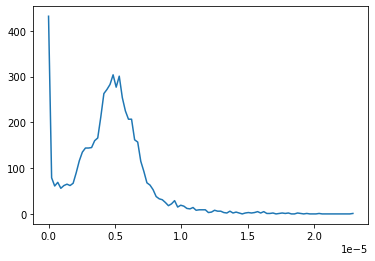

In [7]:
# Getting Backprojected Data
backproj = []
for i in np.arange( len( interPos ) ):
    print( poses[i] * 180 / np.pi )
    bp = compton2.coneVoxel2( sourcePixelsNew[i], interPos[i], \
                            coneDir[i], coneMu[i], 0.08, binSize  ) 
    v = ( bp ).sum( 1 )
    mask2 = np.isnan( v ) | ( v < 1e-20 )
    backproj.append( bp[~mask2] )
    hist, bins = np.histogram( v[~mask2], bins = 100 )
    plt.plot( bins[ :-1 ], hist )
    plt.show()

In [ ]:
# # Getting Rid of Zero Values Events for Backprojected Data
# xmax = sourcePixels[:,0].max()
# zmax = sourcePixels[:,2].max()
# f = int( np.sqrt(xmax**2+zmax**2) - xmax )

# R1 = 30
# R2 = 30 - 2
# H = sourcePixels[:,1].max() - 2
# xcoord = sourcePixels[:, 0]
# ycoord = sourcePixels[:, 1]
# zcoord = sourcePixels[:, 2]
# mask1 = ( np.sqrt( xcoord ** 2 + zcoord ** 2 ) > R1 )
# mask2 = ( np.sqrt( xcoord ** 2 + zcoord ** 2 ) > R2 ) | ( np.abs( ycoord ) > H )
# backproj_New = []
# for i in np.arange( len( interPos ) ): 
#     values1 = backproj[i].copy()
#     values2 = backproj[i].copy()
#     values1.T[mask1] = 0
#     values2.T[mask2] = 0
#     C1 = values1.sum( 1 )
#     C2 = values2.sum( 1 )
#     fraction = C2 / ( C1 + 1e-20 )
#     hist, bins = np.histogram( fraction, bins = 100 )    
#     mask3 = fraction > 0.85
#     backproj_New.append( backproj[i][mask3] )
#     plt.plot( bins[ :-1 ], hist )
#     plt.show()

In [ ]:
backproj_New = []
for i in np.arange( len( interPos ) ):
#     v = ( backproj_New[i] ).sum( 1 )
#     hist, bins = np.histogram( v, bins = 100 )
   
    v = ( backproj[i] ).sum( 1 )
    mask = v > 0.1e-5
    hist, bins = np.histogram( v[mask], bins = 100 )
    backproj_New.append( backproj[i][mask] )
    plt.plot( bins[ :-1 ], hist )
    plt.show()

In [ ]:
# Calculating Sensitivity Map 1
sensMap = []
eps = 1e-10
det = 37
for i in np.arange( len( poses ) ):
    x = np.round( sourcePixelsNew[i][:,0]  ).astype(int)
    y = np.round( sourcePixelsNew[i][:,1] ).astype(int)
    z = np.round( sourcePixelsNew[i][:,2] ).astype(int)
    R = np.sqrt( x ** 2 + y ** 2 + z ** 2)
    rHat = sourcePixelsNew[i] / R[:,np.newaxis]
    c1 = x + det
    c2 = x - det
    d1 = y + det
    d2 = y - det
    a1 = c1 / ( np.sqrt( c1 ** 2 + z ** 2 ) + eps )
    b1 = d1 / ( np.sqrt( d1 ** 2 + z ** 2 ) + eps )
    a2 = c2 / ( np.sqrt( c2 ** 2 + z ** 2 ) + eps )
    b2 = d2 / ( np.sqrt( d2 ** 2 + z ** 2 ) + eps )
    firstsum = np.arcsin( a1 * b1 ) * ( ( -1 ) ** 2 ) + np.arcsin( a1 * b2 ) * ( ( -1 ) ** 3 )
    secondsum = np.arcsin( a2 * b1 ) * ( ( -1 ) ** 3 ) + np.arcsin( a2 * b2 ) * ( ( -1 ) ** 4 )
    sens =  ( firstsum + secondsum ) / ( 4 * np.pi ) 
    sens[z<0]=0
    sensMap.append( sens )
sens1 = np.array( sensMap ).sum(0)
# # sens1[mask2] = 0

In [ ]:
sens_grid = sens1.reshape( sourceX.shape )
a, b = min(sens_grid.flatten()), max(sens_grid.flatten())
for i in np.arange( sourceX.shape[2] ):
    print(i)
    fig, ax = plt.subplots()
    grid = sens_grid[ :, :, i] 
    im = ax.pcolormesh( grid.T, vmin=a, vmax=b, shading = 'gouraud' ) 
    ax.set_xlabel( 'x (mm)', fontsize = 20 )
    ax.set_ylabel( 'z (mm)', fontsize = 20 )
    ax.tick_params( labelsize = 20 )
    cbar = plt.colorbar( im )
    cbar.set_label( label = 'intensity', rotation = 270, fontsize = 15, labelpad = 20 )
    cbar.ax.tick_params( labelsize = 20 )
    plt.show()

In [ ]:
hist, bins = np.histogram( sens1, bins = 100 )
plt.plot(bins[:-1], hist)
plt.show()

In [ ]:
sysresponse = []
N = 0
for i in np.arange( len( backproj_New) ):
    N = backproj_New[i].shape[0] + N
print(N)

In [ ]:
nIter = 1000
eta = 0.001
sensitivity = sens1.copy()
maxsens = sensitivity.max()
lamb = np.ones( len( sourcePixels ) )
for n in np.arange( nIter ):
    print( 'iteration: %i of %i' %( n + 1, nIter ) )
    outerSum = np.zeros( ( len( sourcePixels )  ), dtype = 'float32' )
    ratio = np.zeros( len( sourcePixels ) )
    lamb3D = np.pad( lamb.copy().reshape( sourceX.shape ), 1 )
    sens3D = np.pad( sensitivity.reshape( sourceX.shape ), 1 )
    P_alpha = np.zeros_like( lamb3D )
    for i in np.arange( 1, lamb3D.shape[0] - 1 ):
        for j in np.arange( 1, lamb3D.shape[1] - 1 ):
            for k in np.arange( 1, lamb3D.shape[2] - 1 ):
                if sens3D[i][j][k] > 0:
                    val = -eta * maxsens * \
                        ( np.sign( lamb3D[i][j][k] - lamb3D[i-1][j][k] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i+1][j][k] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i][j-1][k] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i][j+1][k] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i-1][j-1][k] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i-1][j+1][k] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i+1][j-1][k] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i+1][j+1][k] ) + \

                        np.sign( lamb3D[i][j][k] - lamb3D[i-1][j][k-1] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i+1][j][k-1] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i][j-1][k-1] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i][j+1][k-1] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i-1][j-1][k-1] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i-1][j+1][k-1] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i+1][j-1][k-1] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i+1][j+1][k-1] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i][j][k-1]  ) + \

                        np.sign( lamb3D[i][j][k] - lamb3D[i-1][j][k+1] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i+1][j][k+1] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i][j-1][k+1] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i][j+1][k+1] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i-1][j-1][k+1] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i-1][j+1][k+1] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i+1][j-1][k+1] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i+1][j+1][k+1] ) + \
                        np.sign( lamb3D[i][j][k] - lamb3D[i][j][k+1]  ) )
                    P_alpha[i][j][k] = val
                else:
                    P_alpha[i][j][k] = 0
    P_pos = ( 0.5 * ( np.abs( P_alpha ) + P_alpha ) )[ 1:-1, 1:-1, 1:-1 ].flatten()
    P_neg = ( 0.5 * ( np.abs( P_alpha ) - P_alpha ) )[ 1:-1, 1:-1, 1:-1 ].flatten()
    for p in np.arange( len( interPos ) ):
        sysMat = backproj_New[p]
        projExpected = np.dot( sysMat, lamb )
        frac = np.divide( sysMat.T, projExpected, out = np.zeros_like( sysMat.T ), where = projExpected != 0 )
        ratio = ratio + frac.sum(1) 
    lamb = lamb * np.divide( 1, ( sensitivity + P_neg ), out = np.zeros_like( sensitivity ), where = sensitivity != 0 ) * ( ratio + P_pos )
    if ( n == 9 ) | ( n == 19 ) | ( n == 29 ) | ( n == 39 ) | ( n == 49 ) | \
    ( n == 59 ) | ( n == 69 ) | ( n == 79 ) | ( n == 89 ) | ( n == 99 ) | \
    ( n == 199 ) | ( n == 299 ) | ( n == 399 ) | ( n == 499 ) | ( n == 599 ) | \
    ( n == 699 ) | ( n == 799 ) | ( n == 899 ) | ( n == 0 ) | ( n == 149 ):
        f = tables.open_file( '/Users/eframe/Downloads/micro_comp_' + str(n+1) + '.h5', 'w')
        f.create_array('/', 'image', lamb)
        f.close()

In [ ]:
%matplotlib inline
depth = np.array( sourceZ[:,0][0] )[:] + center[2]
xmin, xmax = sourceX[:,0][:,0][0], sourceX[:,0][:,0][-1] + 1
ymin, ymax = sourceY[0,:][:,0][0], sourceY[0,:][:,0][-1] + 1
X, Y = np.mgrid[  xmin:xmax:binSize, ymin:ymax:binSize ]

lamb2 = lamb.copy()

lamb2 = np.fliplr( lamb2.reshape(sourceX.shape)[:,:,:] )
a, b = min(lamb2.flatten()), max(lamb2.flatten())
for i in np.arange( lamb2.shape[2] ):
    fig, ax = plt.subplots()
    grid = lamb2[ :, :, i] 
    im = ax.pcolormesh( X, Y, grid, vmin=a, vmax=b, cmap='jet', shading = 'gouraud' ) 
    ax.set_xlabel( 'x (mm)', fontsize = 20 )
    ax.set_ylabel( 'y (mm)', fontsize = 20 )
    ax.tick_params( labelsize = 20 )
    cbar = plt.colorbar( im )
    cbar.set_label( label = 'intensity', rotation = 270, fontsize = 15, labelpad = 20 )
    cbar.ax.tick_params( labelsize = 20 )
    plt.title( depth[i] )
    print(i, max(lamb2[:,:,i].flatten()))
    plt.show()

In [ ]:
# outfile = '/home/raptor/Downloads/micro_COMP_' + + str(nIter) + '.h5'
# f = tables.open_file( outfile, 'w' )
# f.create_array( '/', 'image', lamb2.flatten() )
# f.close()